# Guild Wars 2 - Dynamic Market Data Processing and Observations 

## Imports, Data Set-Up and Functions

### Imports

In [1]:
import Seeder
import Parser
import Looper
import Trawler
import Ledger
from DataFiles import StaticData
import Colours as CP
from client import GuildWars2Client

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import seaborn as sns
import pandas as pd
import csv
import math

## https://pandas.pydata.org/pandas-docs/stable/visualization.html
## http://pandas.pydata.org/pandas-docs/version/0.13/visualization.html
## https://matplotlib.org/users/pyplot_tutorial.html

plt.style.use(plt.style.available[13])  ##4, 13, 21
sns.set_context("paper")
plt.style.available[13]

All files found!


'seaborn-notebook'

### Style Tester

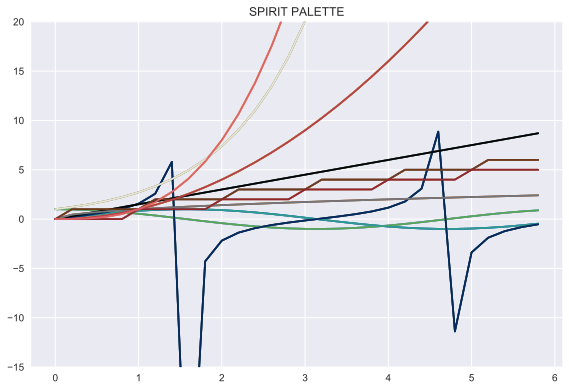

In [2]:
def PaletteTest(colour):
    t = [ t/5.0 for t in range( 30 ) ]
    fig = Figure( figsize=(12.0,15.0), dpi=100) 
    canvas = FigureCanvas(fig)
    direc = 'PaletteOutput/'

    functions = [ math.cos, math.sin, math.tan, lambda x : 1.5*x, 
                  math.exp, math.sqrt, math.ceil,
                  math.floor, lambda x : x**2, lambda x : x**3 ]

    #####################################
    for index, fn in enumerate(functions) :
        palette = colour+"_"+str(index)
        ax = fig.add_subplot( 5, 2, index+1 )
        ax.set_title( palette )
        f = [ fn( x ) for x in t ]
        ax.plot( t, f, color=getattr(CP, palette), markersize=5.0 ) 

    fig.tight_layout()
    fig.savefig(direc + colour + '_PALETTE.svg')
    
    ####################################
    plt.style.use(plt.style.available[13])  ##4, 13, 21     
    plt.title(colour + ' PALETTE')
    for index, fn in enumerate(functions) :
        palette = colour+"_"+str(index)
        f = [ fn( x ) for x in t ]
        plt.plot(t, f, color=getattr(CP, palette))

    plt.ylim( -15, 20 ) # limits the y-axis from 0 to 2500
    plt.tight_layout()
    plt.savefig(direc + colour + '_OVERLAY.svg')
    
palettes = ["KIKI", "CASTLE", "SPIRIT"]
for x in palettes: PaletteTest(x)

### Functions 

#### Item and Recipe Referencers 

In [3]:
def getTrawledItems():
    ## TODO - Set up so that only relevant files are found
    files = [i for i in items if Trawler.checkFile(i, '-summary-', 'cleaned'+ftype)]
## (str(i) + '-summary-cleaned' + ftype)
    return files

def get_components(ids, comps=[]):
    comps.append(ids)
    d = recipes.get(ids, None)
    if d: 
        for x in d:
            for y in d[x]:
                comps = get_components(y[0], comps=comps)
    return comps

#### CSV Parsers and Data Structuring

In [4]:
def read_summary( ids ):
    df = pd.read_csv(direc+str(ids)+"-summary-cleaned"+ftype,
                     skiprows=0,
                     header=None,
                     index_col=0, 
                     usecols=[0,2,3,4,5],
                     parse_dates=[0]
                    )
    df.columns = labels
    df.index.names = ['Date']
    return df

def writeMasterFile(files):
    with open("master-data.gdoc", 'w') as f:
        for x in files:
            with open(direc + str(x) +'-summary-cleaned'+ftype, 'r') as e:
                lines = e.readlines()
                f.write("".join(lines))

def read_master_summary( ids ):
    df = pd.read_csv(direc+"master-data"+ftype,
                     skiprows=0,
                     header=None,
                     index_col=0, 
                     parse_dates=[0]
                    )
    df.columns = ["ID"] + labels
    df.index.names = ['Date']
    return df

def all_to_dict():
    d = {}
    for x in files: d[x] = read_summary(x)
    return d

def dict_to_df(d):
    data = pd.DataFrame.from_dict({(j,i): d[i][j] 
            for i in d.keys() for j in d[i].keys()},
            orient='index')
    data.transpose()
    return data

def all_to_df():
    return dict_to_df(all_to_dict())

#### Lowest Price Generator

In [5]:
def ComplexCraft(ids, l="Sell Price", label=" - Complex Craft Price"):
    def ItemComp(a, b):
        c = (a<=b)*a + (a>b)*b
        ##c["Recipe ID"] = (a<=b)*"ID a" + (a>b)*"ID b"
        return c
    
    label = items[ids][0] + label
    craftcost = 999999999
    buycost = 999999999
    
    if(ids in files):
        buycost = get_plane(item=ids, label=l)
        buycost.columns = [label]
    
    d = recipes.get(ids, None)
    if(d): 
        for x in d:
            subcost = 0
            for y in d[x]:
                t = ComplexCraft(y[0], l)
                if(type(t) == pd.DataFrame): t.columns = [label]
                subcost += t*y[1]
            craftcost = ItemComp(subcost, craftcost)
    
    lowestcost = ItemComp(craftcost, buycost)
    merccost = merchant.get(ids, None)
    if(merccost): lowestcost = ItemComp(lowestcost, merccost)
    return lowestcost

def PersonalCraft( ids, l="Personal Price", label=" - Personal Craft Price" ):
    ## - TODO Craft item based on inventory cost, or merchant/current market price.
    def ItemComp(a, b):
        c = (a<=b)*a + (a>b)*b
        ##c["Recipe ID"] = (a<=b)*"ID a" + (a>b)*"ID b"
        return c
        
    label = items[ids][0] + label
    craftcost = 999999999
    buycost = inventory.get(ids, (999999999,))[0]
    cost = Ledger.getLowestPrice(ids)
    if(cost and cost < buycost): buycost = cost
        
    
    d = recipes.get(ids, None)
    if(d): 
        for x in d:
            subcost = 0
            for y in d[x]:
                t = PersonalCraft(y[0], l)
                if(type(t) == pd.DataFrame): t.columns = [label]
                subcost += t*y[1]
            craftcost = ItemComp(subcost, craftcost)
    
    lowestcost = ItemComp(craftcost, buycost)
    return lowestcost

####  Access Helpers

In [6]:
def get_plane(item=None, label=None, date=None):
    data = data_df.copy()
    i = len(files)
    l = len(labels)
    d = data.shape[1]
            
    def set_a(x):
        t = type(x)
        out = None
        if(t == int or t == str):
            if(t == int):
                if(x < i): out = x
                elif(x in files): out = i-files.index(x)
        return out
        
    def set_b(x):
        t = type(x)
        out = None
        if(t == int or t == str):
            if(t == int):
                if(x < l): out = x
            else:
                if(x in labels): out = labels.index(x)
        return out
    
    def set_c(x):
        t = type(x)
        if(t == int and x < d): out = x
        elif(t == str): out = x
        elif(t == tuple and len(x) == 2):
            if(type(x[0]) == str and type(x[1]) == str): out = x
            else: out = None
        elif(t == list):
            out = None
            ## Todo - handle multiple planes
        else:
            out = None
        return out

    a, b, c = set_a(item), set_b(label), set_c(date)
    
    plane = data
    if(a):
        if(b): plane = data.iloc[(i*(b-1)+a-1):(i*(b-1)+a)]
        else: plane = data.iloc[a-1::i]
    else:
        if(b): plane = data.iloc[(i*(b-1)):(i*(b))]
        else: plane = data
    
    plane = plane.copy().transpose()
    if(c):
        t = type(c)
        if(t == int): plane = plane.iloc[c]
        elif(t == str): plane = plane[c]
        elif(t == tuple): plane = plane[c[0]:c[1]]
        
        
    return plane

#### Plotting Helpers

In [7]:
def split_data( df ):
    p = df.drop(['Buy Qty.', 'Sell Qty.'], axis=1)
    q = df.drop(['Buy Price', 'Sell Price'], axis=1)
    return p, q

def dual_plot( p, q ):
    plt.style.use(plt.style.available[13])  ##4, 13, 21 
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.25, hspace=0.5)
    with pd.plotting.plot_params.use('x_compat', True):
        p['Buy Price'].plot(ax=axes[0,0], color=CP.SPIRIT_0, legend=True)
        p['Sell Price'].plot(ax=axes[0,0], color=CP.SPIRIT_8, legend=True)
        axes[0,0].set_ylabel('Prices') 
        axes[0,0].set_title('Prices')
    with pd.plotting.plot_params.use('x_compat', True):
        q['Buy Qty.'].plot(ax=axes[0,1], color=CP.SPIRIT_0, legend=True)
        q['Sell Qty.'].plot(ax=axes[0,1], color=CP.SPIRIT_8, legend=True)
        axes[0,1].set_ylabel('Quantity') 
        axes[0,1].set_title('Quantity')
    with pd.plotting.plot_params.use('x_compat', True):
        p['Buy Price'].resample('1H').mean().plot(ax=axes[1,0], color=CP.SPIRIT_0, legend=True)
        p['Sell Price'].resample('1H').mean().plot(ax=axes[1,0], color=CP.SPIRIT_8, legend=True)
        axes[1,0].set_ylabel('Prices') 
        axes[1,0].set_title('Prices - 1H Resample')
    with pd.plotting.plot_params.use('x_compat', True):
        q['Buy Qty.'].resample('1H').mean().plot(ax=axes[1,1], color=CP.SPIRIT_0, legend=True)
        q['Sell Qty.'].resample('1H').mean().plot(ax=axes[1,1], color=CP.SPIRIT_8, legend=True)
        axes[1,1].set_ylabel('Quantity') 
        axes[1,1].set_title('Quantity - 1H Resample') 
    
def instaplot( ids ):
    if (ids not in data_dict): data = read_summary(ids)
    else: data = data_dict[ids]
    p, q = split_data(data)
    dual_plot(p, q)

def ColourChoice():
    pass

In [8]:
def PlotSimpleCraft(ids, p=True):
    
    def ItemComp(a, b):
        c = (a<=b)*a + (a>b)*b
        ##c["Recipe ID"] = (a<=b)*"ID a" + (a>b)*"ID b"
        return c
    
    bestcraftcost = 999999999
    if(ids in files):
        buycost = get_plane(item=ids, label='Buy Price')
        buycost.columns = [items[ids][0] + ' - Buy Price']

        d = recipes.get(ids, None)
        if(d):
            for x in d:
                craftcost = 0;
                colour = 3
                ax = None
                if(p):
                    fig, axes = plt.subplots(nrows=2, figsize=(11.5, 8))
                    plt.subplots_adjust(wspace=0.25, hspace=0.4)
                    buycost.plot(ax=axes[0], color=CP.SPIRIT_0, legend=True)
                    buycost.resample('1H').mean().plot(ax=axes[1], color=CP.SPIRIT_0, legend=True)
                    axes[0].set_title(items[ids][0] + ' - Recipe ID:' + str(x))
                    axes[0].set_ylabel("Price")
                    axes[1].set_title(items[ids][0] + ', 1H Resample - Recipe ID:' + str(x))
                    axes[1].set_ylabel("Price")
                for y in d[x]:
                    if(y[0] in files):
                        mat = get_plane(item=y[0], label='Sell Price')
                        mat.columns = [items[y[0]][0] + ' - Sell Price']
                        if(p): 
                            mat.plot(ax=axes[0], color=getattr(CP, 'KIKI_'+str(colour)), legend=True)
                            mat.resample('1H').mean().plot(ax=axes[1], color=getattr(CP, 'KIKI_'+str(colour)), legend=True)
                        mat.columns = [items[ids][0] + ' - Simple Craft Price']
                        craftcost += mat
                    elif(merchant.get(y[0], None)):
                        mat = merchant[y[0]]
                        if(p): ax.axhline(y=mat)
                        craftcost += mat
                    else:
                        print("No price data found for Item " + Sstr(y[0]))
                    colour -= 1
                if(p): 
                    craftcost.plot(ax=axes[0], color=CP.CASTLE_9, legend=True)
                    craftcost.resample('1H').mean().plot(ax=axes[1], color=CP.CASTLE_9, legend=True)
                bestcraftcost = ItemComp(craftcost, bestcraftcost)
        else: print("ERROR! No crafting recipe found for this item.")
    else: print("ERROR! No data found for this item.")
    return bestcraftcost

In [9]:
def PlotComplexCraft(ids, simplecraft=None):
    buycost = get_plane(item=ids, label='Buy Price')
    buycost.columns = [items[ids][0] + ' - Buy Price']
    sellcost = get_plane(item=ids, label='Sell Price')
    sellcost.columns = [items[ids][0] + ' - Sell Price']
    if(type(simplecraft) == None): simplecraft = PlotSimpleCraft(ids, p=False)
    complexcraft = ComplexCraft(ids)
    complexprofit = complexcraft*1.1765
    complexprofit.columns=["Profitable Sell Price"]
    personalcraft = PersonalCraft(ids)
    personalprofit = personalcraft*1.1765
    
    fig, axes = plt.subplots(nrows=2, figsize=(11.5, 8))
    plt.subplots_adjust(wspace=0.25, hspace=0.4)
    
    buycost.plot(ax=axes[0], color=CP.SPIRIT_8, legend=True)
    sellcost.plot(ax=axes[0], color=CP.SPIRIT_0, legend=True)
    simplecraft.plot(ax=axes[0], color=CP.CASTLE_9, legend=True)
    complexcraft.plot(ax=axes[0], color=CP.CASTLE_8, legend=True)
    complexprofit.plot(ax=axes[0], color=CP.CASTLE_8, alpha=0.33, legend=True)
##    axes[0].axhline(y=personalcraft, color=CP.KIKI_4)
##    axes[0].axhline(y=personalprofit, color=CP.KIKI_4, alpha=0.33)
    axes[0].set_title(items[ids][0])
    axes[0].set_ylabel("Price")
    
    buycost.resample('1H').mean().plot(ax=axes[1], color=CP.SPIRIT_8, legend=True)
    sellcost.resample('1H').mean().plot(ax=axes[1], color=CP.SPIRIT_0, legend=True)
    simplecraft.resample('1H').mean().plot(ax=axes[1], color=CP.CASTLE_9, legend=True)
    complexcraft.resample('1H').mean().plot(ax=axes[1], color=CP.CASTLE_8, legend=True)
    complexprofit.resample('1H').mean().plot(ax=axes[1], color=CP.CASTLE_8, alpha=0.33, legend=True)
##    axes[1].axhline(y=personalcraft, color=CP.KIKI_4)
##    axes[1].axhline(y=personalprofit, color=CP.KIKI_4, alpha=0.33)
    axes[1].set_title(items[ids][0] + ', 1H Resample')
    axes[1].set_ylabel("Price")
    
    return complexprofit

In [10]:
def PlotProfitMargins(ids, complexprofit=None, personalprofit=None):
    buycost = get_plane(item=ids, label='Buy Price')
    buycost.columns = ['Buy Price']
    sellcost = get_plane(item=ids, label='Sell Price')
    sellcost.columns = ['Sell Price']
    if(type(complexprofit) == None): complexprofit = ComplexCraft(ids)*1.1765
    if(type(personalprofit) == None): personalprofit = PersonalCraft(ids)*1.1765
    complexprofit.columns = ['Buy Price']
    instaprofit = (buycost-complexprofit)-1
    instamargin = instaprofit*100/complexprofit
    instaprofit.columns = ['Profit at Instant-Sell']
    instamargin.columns = ['Margin at Instant-Sell']
    complexprofit.columns = ['Sell Price']
    longprofit = sellcost-complexprofit
    longmargin = longprofit*100/complexprofit
    longprofit.columns = ['Profit at Market Value']
    longmargin.columns = ['Margin at Market Value']
    
    ## TODO - Add personal profit margins into graph.
    
    
    fig, axes = plt.subplots(nrows=2, figsize=(11.5, 8))
    plt.subplots_adjust(wspace=0.25, hspace=0.4)
    
    instaprofit.plot(ax=axes[0], color=CP.KIKI_7, legend=True)
    longprofit.plot(ax=axes[0], color=CP.KIKI_6, legend=True)
    instamargin.plot(ax=axes[0], color=CP.KIKI_7, alpha=0.33, secondary_y=True, legend=True)
    longmargin.plot(ax=axes[0], color=CP.KIKI_6, alpha=0.33, secondary_y=True, legend=True)
    axes[0].axhline(y=0, color=CP.SPIRIT_5)
    axes[0].set_title(items[ids][0])
    axes[0].set_ylabel("Price")
    axes[0].right_ax.set_ylabel('Profit Margin (%)')
    
    instaprofit.resample('1H').mean().plot(ax=axes[1], color=CP.KIKI_7, legend=True)
    longprofit.resample('1H').mean().plot(ax=axes[1], color=CP.KIKI_6, legend=True)
    instamargin.resample('1H').mean().plot(ax=axes[1], color=CP.KIKI_7, alpha=0.33, secondary_y=True, legend=True)
    longmargin.resample('1H').mean().plot(ax=axes[1], color=CP.KIKI_6, alpha=0.33, secondary_y=True, legend=True)
    axes[1].axhline(y=0, color=CP.SPIRIT_5)
    axes[1].set_title(items[ids][0] + ', 1H Resample')
    axes[1].set_ylabel("Price")
    axes[1].right_ax.set_ylabel('Profit Margin (%)')

In [11]:
def PlotCraftAndProfit(ti):
    simplecraft = PlotSimpleCraft(ti)
    complexprofit = PlotComplexCraft(ti, simplecraft)
    PlotProfitMargins(ti, complexprofit)
    return simplecraft, complexprofit

### Data Initialization

#### Target Item and Related Structures
Determines how the rest of the Jupyter Notebook runs, based on iiitial set-up and item id chosen.

In [12]:
target_item = ti = 71334
items, recipes, merchant, inventory = Seeder.SeedLists()

####  Set File Paths and Generate Data
Change file paths for the whole notebook here, and generate relevant data in one cell.

In [13]:
direc = 'TextFiles/'
ftype = '.txt'
labels = [ "Buy Qty.", "Buy Price", "Sell Qty.", "Sell Price" ]
comps = get_components( ti )
files = [x for x in getTrawledItems() if x in comps]
print("Relevant Files: " + str(files))

data_dict = all_to_dict()
data_examp = read_summary('example')
data_df = dict_to_df(data_dict)
data_df

Relevant Files: [71334, 46747, 46741, 46739, 19790, 19748, 19747, 19744, 19743, 19742, 19741, 19740, 19739, 19736, 19735, 19734, 19733, 19731, 19730, 19729, 19728, 19721]


2017-11-01 22:26:05  2017-11-01 22:30:54  \
Buy Price  19721                 2420                 2401   
           19728                  282                  280   
           19729                  156                  155   
           19730                  320                  322   
           19731                  432                  434   
           19733                  569                  569   
           19734                  635                  635   
           19735                  616                  617   
           19736                  950                  950   
           19739                  290                  286   
           19740                  598                  598   
           19741                  152                  151   
           19742                  301                  301   
           19743                  311                  311   
           19744                  641                  641   
           19747                  121                  120   
           19748                   44                   44   
           19790                   68                   68   
           46739                81597                81597   
           46741                42371                42370   
           46747                  160                  160   
           71334               117993               117993   
Buy Qty.   19721               155223               154792   
           19728               435135               434388   
           19729               756361               755248   
           19730               118840               118871   
           19731               103309               103303   
           19733                37925                37925   
           19734                26518                26493   
           19735               178342               178496   
...                               ...                  ...   
Sell Price 19744                  742                  742   
           19747                  149                  135   
           19748                   45                   45   
           19790                   78                   78   
           46739                91397                91395   
           46741                49999                49999   
           46747                  177                  178   
           71334               157400               157500   
Sell Qty.  19721               987853               988033   
           19728               221403               221601   
           19729              1503797              1504708   
           19730                93834                93799   
           19731               149006               149401   
           19733                70696                70913   
           19734                71593                71641   
           19735               235494               235180   
           19736                68645                69004   
           19739               184654               184582   
           19740                71015                70957   
           19741               320134               319970   
           19742               141593               141593   
           19743               328984               329647   
           19744                74853                74873   
           19747               940058               940327   
           19748             10551782             10552521   
           19790               107728               107593   
           46739                 1674                 1678   
           46741                 2127                 2126   
           46747               113459               113189   
           71334                 1218                 1216   

                  2017-11-01 22:35:57  2017-11-01 22:40:54  \
Buy Price  19721                 2400                 2425   
           19728                  280            

## Explanation of Graphs and Game Mechanics

### Introduction to Guild Wars 2 and its Data 

In this graph below, two things are plotted. The buy and sell price of a single arbitrary item. As one can see, the prices of an item can vary greatly. (Side note: The currency in game is gold, silver and copper coins. 100 coppers is a silver, 100 silvers is a gold. That means for prices, 10,000 is 1 gold. For non-players, a basic level-capped weapon can run from 1 to 10 gold, depending on a variety of things.)

The buy price of an item is the highest price that another player is willing to buy the item for.
Conversely, the sell price of the item is the lowest price that another player is selling the item for.
The price graphs track the "best" price, that is, the cheapest you can buy or the highest you can sell immediately.

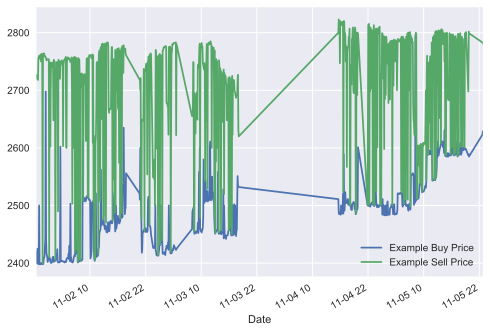

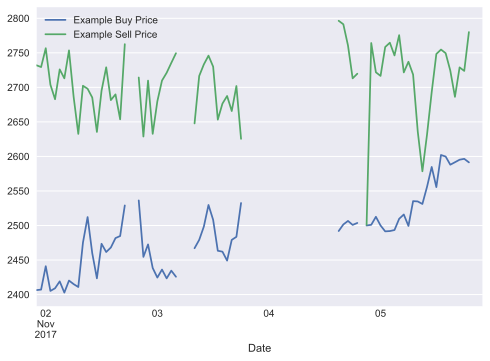

In [14]:
example1 = pd.DataFrame({ 'Example Sell Price' : data_examp['Sell Price'], 
                         'Example Buy Price' : data_examp['Buy Price'] })

example1.plot()
example1 = example1.resample('1H').mean()
example1.plot()
None

In the next graph, the buy and sell quantities (or orders) of the item are plotted.

The buy quantity refers to the number of players who are currently wanting to buy the item.
The sell quantity refers to the number of players who are currently attempting to sell the item.
The buy and sell orders can all be of different prices, so not all 1,000,000 are being sold at the cost listed above.

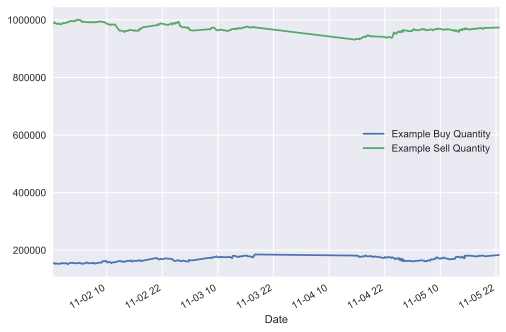

In [15]:
example2 = pd.DataFrame({ 'Example Sell Quantity' : data_examp['Sell Qty.'], 
                         'Example Buy Quantity' : data_examp['Buy Qty.'] })

example2.plot()
None

The below graph is a zoomed in section of the prices graph from above. There are a few important things to note:

1. Because of how the buy and sell orders work (and attempt to cancel out), the sell price will always be at least one copper higher than the buy price. Another way to view the data, is there are no items to buy or sell between the two lines.
2. Because the best price can be determined by a single item, prices can fluctuate or spike wildly. However, quantity is not affected in this way, making any spikes **highly** unusual.
3. When selling an item, you will only make 85% of the cost that you sell it for. So selling a weapon for a gold, will earn you 85 silver. This only matters if the intent is to play the market, rather than get gear as cheaply as possible
4. There are 1000's of items. I've focused on a few, and in those, some cannot be sold, bought, or crafted. Of course, some are rarer and/or better than others. Others can have multiple ways to craft it meaning finding an optimal price becomes more than just what the top-level item buys or sells for. 
5. All of the data is taken from the GW2 API in real time, or has been save from it. It goes down from time to time, and can is often responsible for any long, perfectly straight lines in the data graphs.

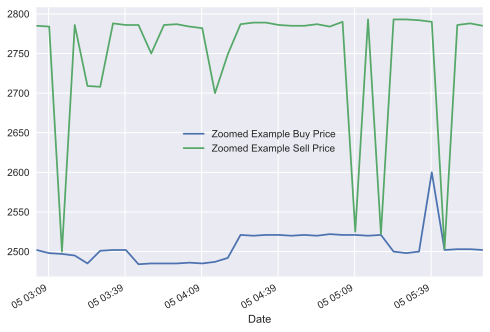

In [16]:
example3 = pd.DataFrame({ 'Zoomed Example Sell Price' : data_examp['Sell Price']["2017-11-05 03:00:00" : "2017-11-05 06:00:00"], 
                         'Zoomed Example Buy Price' : data_examp['Buy Price']["2017-11-05 03:00:00" : "2017-11-05 06:00:00"] })

example3.plot()
None

### Data Analasys

#### Quick Examples of Homemade Slicing Function

In [17]:
get_plane(item=ti, date="2017-11-01 22")

Buy Price Buy Qty. Sell Price Sell Qty.
                        71334    71334      71334     71334
2017-11-01 22:26:05  117993.0    535.0   157400.0    1218.0
2017-11-01 22:30:54  117993.0    535.0   157500.0    1216.0
2017-11-01 22:35:57  130000.0    540.0   157500.0    1215.0
2017-11-01 22:40:54  130000.0    540.0   157049.0    1241.0
2017-11-01 22:45:54  130000.0    540.0   157048.0    1242.0
2017-11-01 22:50:54  130000.0    539.0   157048.0    1242.0
2017-11-01 22:55:54  130000.0    539.0   157048.0    1242.0

In [18]:
get_plane(label="Buy Price", date=("2017-11-01 22:30", "2017-11-01 22:45"))

Buy Price                                            \
                        19721  19728  19729  19730  19731  19733  19734   
2017-11-01 22:30:54    2401.0  280.0  155.0  322.0  434.0  569.0  635.0   
2017-11-01 22:35:57    2400.0  280.0  150.0  313.0  432.0  569.0  635.0   
2017-11-01 22:40:54    2425.0  280.0  153.0  313.0  432.0  566.0  635.0   
2017-11-01 22:45:54    2403.0  280.0  155.0  313.0  432.0  566.0  635.0   

                                            ...                          \
                     19735  19736  19739    ...     19742  19743  19744   
2017-11-01 22:30:54  617.0  950.0  286.0    ...     301.0  311.0  641.0   
2017-11-01 22:35:57  617.0  949.0  290.0    ...     301.0  312.0  641.0   
2017-11-01 22:40:54  618.0  949.0  290.0    ...     301.0  312.0  641.0   
2017-11-01 22:45:54  618.0  949.0  286.0    ...     301.0  312.0  641.0   

                                                                           
                     19747 19748 19790    46739    46741  46747     71334  
2017-11-01 22:30:54  120.0  44.0  68.0  81597.0  42370.0  160.0  117993.0  
2017-11-01 22:35:57  119.0  41.0  62.0  81596.0  42370.0  160.0  130000.0  
2017-11-01 22:40:54  119.0  41.0  62.0  81596.0  42370.0  160.0  130000.0  
2017-11-01 22:45:54  119.0  41.0  62.0  80713.0  42370.0  160.0  130000.0  

[4 rows x 22 columns]

In [19]:
get_plane(item=ti, label="Buy Price", date="2017-11-09 14")

Buy Price
                        71334
2017-11-09 14:04:00  125001.0
2017-11-09 14:09:00  125002.0
2017-11-09 14:14:00  125002.0
2017-11-09 14:19:00  125002.0
2017-11-09 14:24:00  125002.0
2017-11-09 14:29:00  125002.0
2017-11-09 14:34:00  125002.0
2017-11-09 14:39:00  125002.0
2017-11-09 14:44:00  125002.0
2017-11-09 14:49:00  125002.0
2017-11-09 14:54:00  125005.0
2017-11-09 14:59:00  125005.0

In [20]:
get_plane(item=ti).describe()

Buy Price     Buy Qty.     Sell Price    Sell Qty.
               71334        71334          71334        71334
count    4587.000000  4587.000000    4587.000000  4587.000000
mean   126029.890778   444.544583  150732.004142  1498.731851
std      4651.064052    75.391595    4508.203398   174.185646
min    117993.000000   338.000000  118117.000000  1113.000000
25%    122551.000000   376.000000  149648.500000  1360.000000
50%    125005.000000   436.000000  150400.000000  1488.000000
75%    127209.000000   500.000000  151904.000000  1660.000000
max    155057.000000   645.000000  158088.000000  1830.000000

#### Quick Plot of Target Item Data

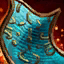

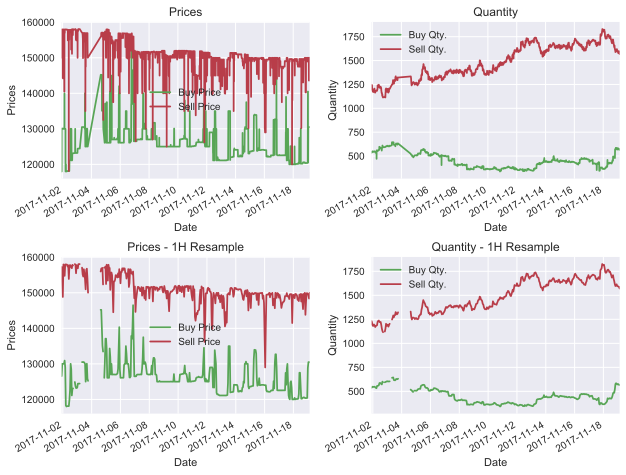

In [21]:
test = Image(items[ti][1])
display(test)
instaplot(ti)

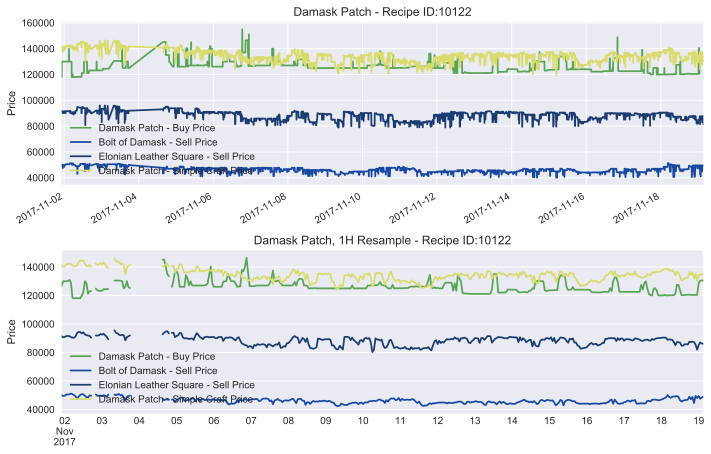

In [22]:
simplecraft = PlotSimpleCraft(ti)

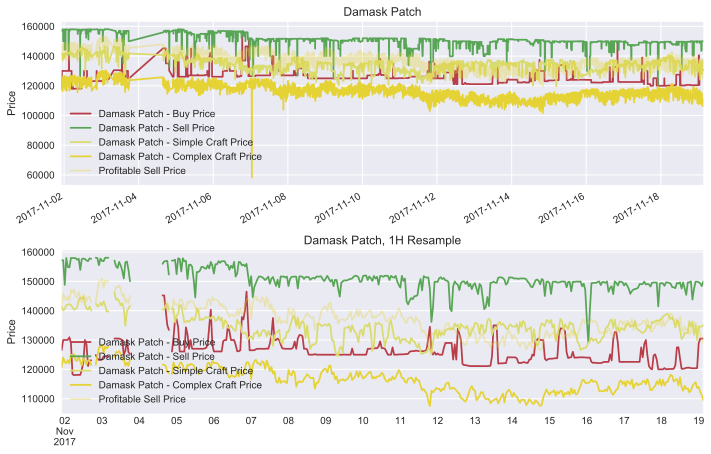

In [23]:
complexprofit = PlotComplexCraft(ti, simplecraft=simplecraft)

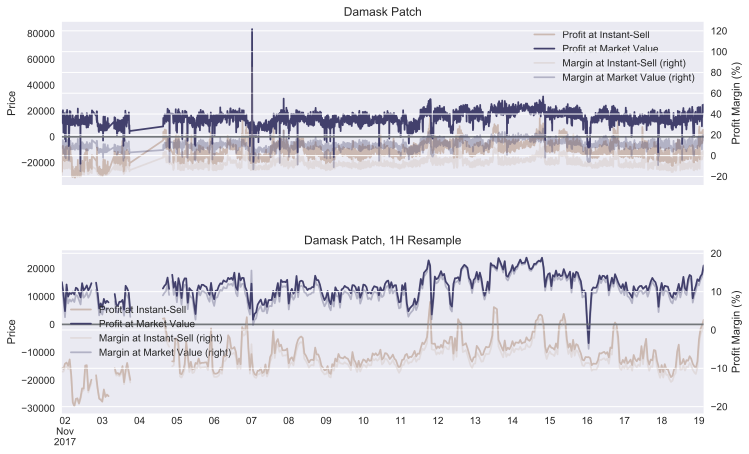

In [24]:
PlotProfitMargins(ti, complexprofit)

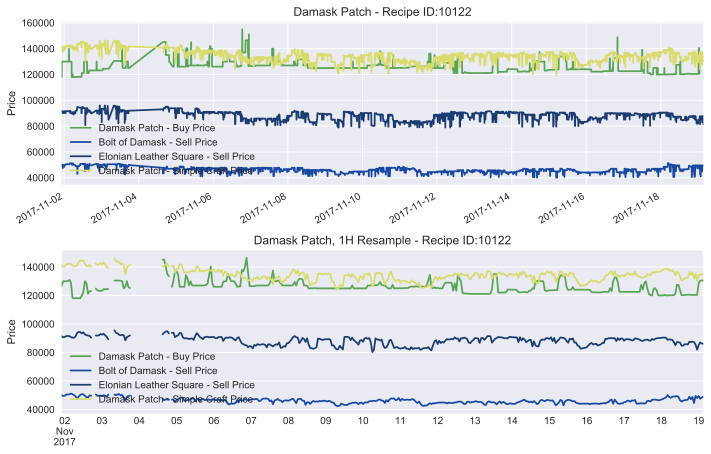

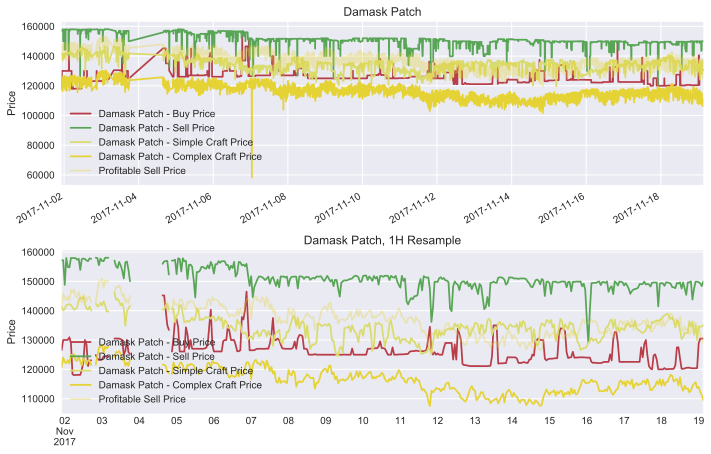

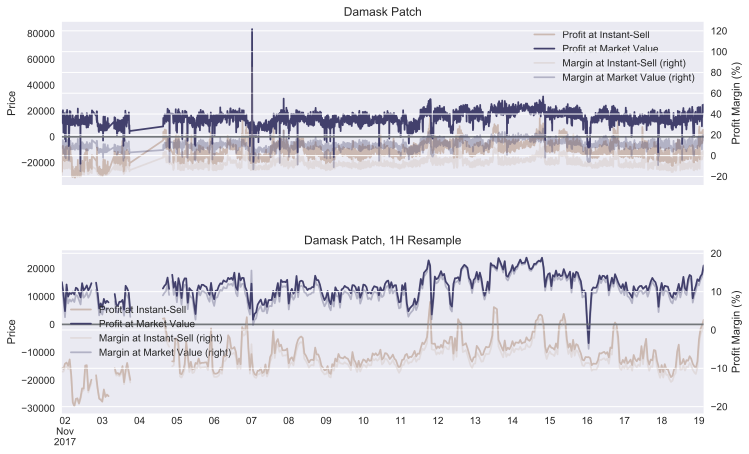

In [25]:
simplecraft, complexprofit = PlotCraftAndProfit(ti)

In [26]:
complexprofit.nsmallest(3, 'Sell Price')

Sell Price
2017-11-07 00:49:15   68509.948
2017-11-14 20:04:43  119595.931
2017-11-14 18:34:43  120951.259

In [27]:
spike = get_plane(label='Sell Price', date=("2017-11-07 00:49"))
spike = spike.transpose()
spike

2017-11-07 00:49:15
Sell Price 19721               2806.0
           19728                  0.0
           19729                151.0
           19730                336.0
           19731                  0.0
           19733                610.0
           19734                736.0
           19735                749.0
           19736               1056.0
           19739                  0.0
           19740                620.0
           19741                  0.0
           19742                363.0
           19743                  0.0
           19744                745.0
           19747                150.0
           19748                 42.0
           19790                 78.0
           46739              83496.0
           46741              47490.0
           46747                178.0
           71334             151796.0

In [28]:
spike = get_plane(label='Sell Price', date=("2017-11-07 00:35", "2017-11-07 01:00"))
spike = spike.transpose()
spike

2017-11-07 00:39:15  2017-11-07 00:44:15  \
Sell Price 19721               2807.0               2608.0   
           19728                278.0                278.0   
           19729                178.0                151.0   
           19730                339.0                339.0   
           19731                484.0                484.0   
           19733                606.0                606.0   
           19734                736.0                736.0   
           19735                750.0                750.0   
           19736               1056.0               1056.0   
           19739                289.0                288.0   
           19740                618.0                621.0   
           19741                174.0                179.0   
           19742                363.0                363.0   
           19743                373.0                372.0   
           19744                745.0                745.0   
           19747                149.0                150.0   
           19748                 48.0                 45.0   
           19790                 78.0                 78.0   
           46739              83499.0              83499.0   
           46741              47488.0              47489.0   
           46747                178.0                178.0   
           71334             151797.0             151797.0   

                  2017-11-07 00:49:15  2017-11-07 00:54:15  \
Sell Price 19721               2806.0               2804.0   
           19728                  0.0                274.0   
           19729                151.0                175.0   
           19730                336.0                335.0   
           19731                  0.0                477.0   
           19733                610.0                610.0   
           19734                736.0                736.0   
           19735                749.0                745.0   
           19736               1056.0               1056.0   
           19739                  0.0                288.0   
           19740                620.0                618.0   
           19741                  0.0                178.0   
           19742                363.0                363.0   
           19743                  0.0                370.0   
           19744                745.0                745.0   
           19747                150.0                150.0   
           19748                 42.0                 48.0   
           19790                 78.0                 78.0   
           46739              83496.0              83296.0   
           46741              47490.0              47489.0   
           46747                178.0                177.0   
           71334             151796.0             150999.0   

                  2017-11-07 00:59:15  
Sell Price 19721               2806.0  
           19728                270.0  
           19729                170.0  
           19730                336.0  
           19731                477.0  
           19733                609.0  
           19734                736.0  
           19735                748.0  
           19736               1056.0  
           19739                288.0  
           19740                618.0  
           19741                175.0  
           19742                363.0  
           19743                310.0  
           19744                745.0  
           19747                149.0  
           19748                 42.0  
           19790                 78.0  
           46739              83296.0  
           46741              47489.0  
           46747                177.0  
           71334             150999.0

In [29]:
spike = get_plane(label='Sell Qty.', date=("2017-11-07 00:35", "2017-11-07 01:00"))
spike = spike.transpose()
spike

2017-11-07 00:39:15  2017-11-07 00:44:15  2017-11-07 00:49:15  \
Buy Qty. 19721             174917.0             174993.0             174915.0   
         19728             425547.0             425383.0                  0.0   
         19729             750675.0             750247.0             747294.0   
         19730             110322.0             110295.0             110230.0   
         19731             108479.0             108728.0                  0.0   
         19733              35554.0              35554.0              35428.0   
         19734              26416.0              26416.0              26381.0   
         19735             177648.0             177622.0             177539.0   
         19736              21331.0              21349.0              21184.0   
         19739             181042.0             180810.0                  0.0   
         19740              46306.0              46302.0              46302.0   
         19741              91114.0              90999.0                  0.0   
         19742              34360.0              34355.0              34355.0   
         19743              85543.0              85759.0                  0.0   
         19744              34701.0              34701.0              34767.0   
         19747             126661.0             126627.0             126033.0   
         19748            1472563.0            1472286.0            1471884.0   
         19790              53894.0              53894.0              53894.0   
         46739               3438.0               3438.0               3439.0   
         46741               6444.0               6444.0               6442.0   
         46747             230461.0             230461.0             230551.0   
         71334                504.0                504.0                504.0   

                2017-11-07 00:54:15  2017-11-07 00:59:15  
Buy Qty. 19721             174603.0             174196.0  
         19728             424981.0             424688.0  
         19729             747122.0             747218.0  
         19730             110043.0             109977.0  
         19731             108290.0             108112.0  
         19733              35478.0              35458.0  
         19734              26371.0              26371.0  
         19735             177547.0             177058.0  
         19736              21175.0              21175.0  
         19739             180401.0             180332.0  
         19740              46396.0              46396.0  
         19741              90694.0              90175.0  
         19742              34313.0              34213.0  
         19743              85496.0              85132.0  
         19744              34757.0              34747.0  
         19747             125783.0             125715.0  
         19748            1471108.0            1469800.0  
         19790              53894.0              53894.0  
         46739               3439.0               3447.0  
         46741               6442.0               6440.0  
         46747             230551.0             230051.0  
         71334                500.0                500.0

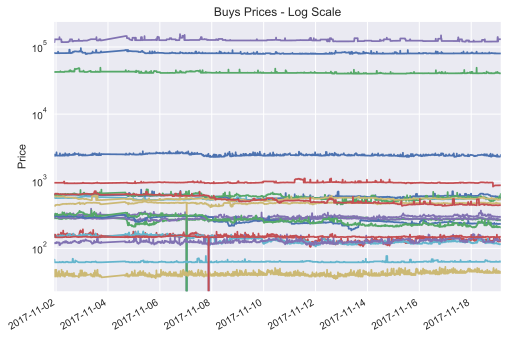

In [30]:
##temp3 = pd.DataFrame( {(items[k][0] + " Buy Price") : data_dict[k]['Buy Price'] for k in files} )
temp3 = get_plane(label="Buy Price")
plt3 = temp3.plot(logy=True, legend=False)
plt3.set_title("Buys Prices - Log Scale")
plt3.set_ylabel("Price")
plt3.plot(colourmap="cubehelix")
None

In [31]:
## Look at large quantity spikes, and relative prices